# NLP Embedding Generation

This notebook implements the NLP components of the project:
1.  **Context-Aware Chunking**: Demonstrates how we preserve metadata (Title, URL) in every text chunk to prevent context loss.
2.  **Nomic Embedding Generation**: We calculate new embeddings using the `nomic-embed-text-v1.5` model as required by the "Student Implementation" section of the prompt.
3.  **Quality Evaluation**: We use **Silhouette Scores** to scientifically compare the provided embeddings (MPNet, BGE) against our custom Nomic embeddings to see which best separates companies by sector.

In [1]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Navigate to your project folder
# CHANGE THIS PATH if you uploaded it somewhere else in Drive
project_path = '/content/drive/MyDrive/advanced-portfolio-hedging'
os.chdir(project_path)

# 3. Install your project + dependencies
# This installs 'adv_hedging' and libraries like sentence-transformers, einops, etc.
!pip install -e .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Obtaining file:///content/drive/MyDrive/advanced-portfolio-hedging
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for adv_hedging (pyproject.toml) ... done
  Created wheel for adv_hedging: filename=adv_hedging-0.1.0-0.editable-py3-none-any.whl size=1451 sha256=88bbcb7f554407745c884797a5691a1305788a1154f0f6b59d461ff67c2c8317
  Stored in directory: /tmp/pip-ephem-wheel-cache-aypvkqi3/wheels/f3/30/b6/a633709c55013204d1ce9099798d50782d2899636077dc9ec4
Successfully built adv_hedging
  Attempting uninstall: adv_hedging
    Found existing installation: adv_hedging 0.1.0
    Uninstalling adv_hedging-0.1.0:
      Successfully uninstalled adv_hedging-0.1.0


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

from adv_hedging.data.loaders import load_wiki_data
from adv_hedging.nlp.text_processing import chunk_text_with_metadata, create_metadata_header
from adv_hedging.config import PROCESSED_DATA_DIR

# Setup Device (GPU/MPS/CPU)
if torch.cuda.is_available():
    device = "cuda"
    print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = "mps"
    print("✅ Using Apple Silicon GPU (MPS)")
else:
    device = "cpu"
    print("⚠️ GPU not found. Using CPU (this will be slower).")

✅ Using GPU: Tesla T4


## 1. Context-Aware Chunking Demo
The project prompt highlights a "Critical Insight": if you split a long Wikipedia page into chunks, the later chunks (e.g., "History of 2005") lose the context that they are about "Apple Inc."

We solved this in `src/adv_hedging/nlp/text_processing.py` by prepending the Title and URL to **every** chunk. Let's verify it works.

In [6]:
df = load_wiki_data()

# Pick a long article (Apple Inc.)
target_ticker = 'AAPL'
row = df[df['ticker'] == target_ticker].iloc[0]

# Generate header
header = create_metadata_header(row)
print(f"METADATA HEADER:\n{header}")
print("-" * 40)

# Chunk the content
chunks = chunk_text_with_metadata(
    row['content'],
    metadata_header=header,
    chunk_size=300,  # Small size to force multiple chunks
    overlap=50
)

print(f"Generated {len(chunks)} chunks for {row['name']}.")
print("-" * 40)
print(f"CHUNK 1 (Start):\n{chunks[0][:200]}...")
print("-" * 40)
print(f"CHUNK 5 (Deep inside article):\n{chunks[4][:200]}...")
print("\n✅ Verification: Notice that Chunk 5 still starts with 'Title: Apple Inc.'")

METADATA HEADER:
Title: Apple Inc.
URL: https://en.wikipedia.org/wiki/Apple_Inc.
Sector: Information Technology
Content:

----------------------------------------
Generated 53 chunks for Apple Inc.
----------------------------------------
CHUNK 1 (Start):
Title: Apple Inc.
URL: https://en.wikipedia.org/wiki/Apple_Inc.
Sector: Information Technology
Content:
Apple Inc. is an American multinational corporation and technology company headquartered in Cupe...
----------------------------------------
CHUNK 5 (Deep inside article):
Title: Apple Inc.
URL: https://en.wikipedia.org/wiki/Apple_Inc.
Sector: Information Technology
Content:
Despite being pioneering as a mass-marketed GUI computer, the Lisa suffered from high costs and ...

✅ Verification: Notice that Chunk 5 still starts with 'Title: Apple Inc.'


## 2. Generate Nomic Embeddings
The parquet file provided `mpnet` and `bge` embeddings, but we calculate **Nomic v1.5** embeddings ourselves.

**Nomic Prefix Strategy:**
The prompt suggests experimenting with prefixes. Since our goal is to separate companies by sector (clustering) or find hedge peers (retrieval), we will generate embeddings using the `clustering:` prefix, which is optimized for grouping semantically similar points.

In [7]:
# Configuration for Nomic
MODEL_NAME = 'nomic-ai/nomic-embed-text-v1.5'
PREFIX = "clustering: " # Recommended for grouping tasks

# Check if we already saved them to avoid re-running on every restart
nomic_path = PROCESSED_DATA_DIR / "nomic_embeddings.parquet"

if nomic_path.exists():
    print("Loading pre-computed Nomic embeddings...")
    df_nomic = pd.read_parquet(nomic_path)
    # Merge into main dataframe
    df['embedding_nomic'] = df_nomic['embedding_nomic']
else:
    print(f"Downloading {MODEL_NAME} to {device}...")
    model = SentenceTransformer(MODEL_NAME, trust_remote_code=True)
    model.to(device)

    # Prepare text: We use the context-aware chunks,
    # but for simplicity in this specific step, we will embed the full "context-rich" string
    # (or the first 8192 tokens, which Nomic supports).

    # Apply prefix
    texts_to_embed = [PREFIX + create_metadata_header(r) + r['content'] for _, r in df.iterrows()]

    print(f"Generating embeddings for {len(texts_to_embed)} documents...")

    embeddings = model.encode(
        texts_to_embed,
        convert_to_numpy=True,
        show_progress_bar=True,
        device=device,
        batch_size= 1
    )

    # Store and Save
    df['embedding_nomic'] = list(embeddings)

    # Save just the embeddings to processed/ for future use
    df[['ticker', 'embedding_nomic']].to_parquet(nomic_path)
    print("✅ Embeddings saved.")

df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_hf_nomic_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Generating embeddings for 650 documents...


Batches:   0%|          | 0/650 [00:00<?, ?it/s]

✅ Embeddings saved.


,ticker,name,sector,industry,content,URL,title,embedding_mpnet,embedding_bge_large,embedding_bge_small,embedding_nomic
0,ZTS,Zoetis Inc,Health Care,Pharmaceuticals,Title: Zoetis\nURL: https://en.wikipedia.org/w...,https://en.wikipedia.org/wiki/Zoetis,Zoetis,"[0.014501823, -0.0009807413, -0.02404803, -0.0...","[0.0001828246, -0.026973305, 0.024251422, 0.01...","[0.020133665, -0.008513564, -0.022554256, 0.02...","[0.9784951, 2.0996761, -4.0683155, -0.23845528..."
1,ZS,Zscaler Inc,Information Technology,Software,Title: Zscaler\nURL: https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/Zscaler,Zscaler,"[0.009020114, -0.012889062, -0.011095319, -0.0...","[-0.0014631954, 0.0033661372, 0.021692174, -0....","[-0.022805821, -0.059095662, -0.06233933, -0.0...","[0.6539903, 2.5000582, -3.9741323, -0.19325908..."
2,ZM,Zoom Communications Inc,Information Technology,Software,Title: Zoom Communications\nURL: https://en.wi...,https://en.wikipedia.org/wiki/Zoom_Communications,Zoom Communications,"[0.017792817, -0.048861224, -0.009158679, -0.0...","[0.013439191, -0.027326003, -0.008322666, 0.01...","[-0.035346173, -0.02221711, -0.0278312, -0.031...","[0.395564, 1.123163, -2.7572944, 0.301003, 0.7..."
3,ZION,Zions Bancorp NA,Financials,Banks,Title: Zions Bancorporation\nURL: https://en.w...,https://en.wikipedia.org/wiki/Zions_Bancorpora...,Zions Bancorporation,"[-0.01601603, -0.030419953, -0.0146953575, -0....","[0.008454562, -0.023495518, -0.0023520405, 0.0...","[-0.013878664, -0.017782524, -0.07974591, 0.01...","[0.56695807, 2.5677414, -3.6998448, -0.5797065..."
4,ZBH,Zimmer Biomet Holdings Inc,Health Care,Health Care Equipment & Supplies,Title: Zimmer Biomet\nURL: https://en.wikipedi...,https://en.wikipedia.org/wiki/Zimmer_Biomet,Zimmer Biomet,"[-0.0011577223, -0.04769175, -0.008060667, -0....","[0.008194411, -0.006104517, 0.022345973, 0.023...","[-0.0069796643, -0.0045109824, -0.07010397, 0....","[0.5464734, 2.03905, -3.7901025, -0.22799063, ..."


## 3. Evaluation: Silhouette Score
Before running the backtest, we use the **Silhouette Score** to measure how well each model groups companies by their official GICS Sector.

* **Higher Score** = The embedding model naturally groups "Energy" companies with other "Energy" companies.
* **Hypothesis**: The model with the highest silhouette score captures the best "business meaning" and should be our primary candidate for Hedging.

In [8]:
# List of embedding columns to test
# We compare the ones provided in the file vs. the one we just made (Nomic)
models_to_test = ['embedding_mpnet', 'embedding_bge_large', 'embedding_bge_small']

if 'embedding_nomic' in df.columns:
    models_to_test.append('embedding_nomic')

sector_labels = df['sector'].values
results = []

print("Calculating Silhouette Scores (Higher is Better)...")

for col in models_to_test:
    # Stack embeddings into a 2D matrix
    # Some rows might be None if generation failed, drop them
    valid_mask = df[col].notna()
    emb_matrix = np.stack(df.loc[valid_mask, col].values)
    labels = sector_labels[valid_mask]

    # Calculate Score
    score = silhouette_score(emb_matrix, labels, metric='cosine')

    results.append({'Model': col, 'Silhouette Score': score})

# Display sorted results
results_df = pd.DataFrame(results).sort_values('Silhouette Score', ascending=False)
display(results_df)

best_model = results_df.iloc[0]['Model']
print(f"\n🏆 Winner: {best_model}")
print("We will use this model for the Nearest Neighbor hedging in Notebook 03.")

Calculating Silhouette Scores (Higher is Better)...


,Model,Silhouette Score
1,embedding_bge_large,0.057452
0,embedding_mpnet,0.039889
2,embedding_bge_small,0.031885
3,embedding_nomic,-0.118651



🏆 Winner: embedding_bge_large
We will use this model for the Nearest Neighbor hedging in Notebook 03.


## 4. Visualization
Let's visually confirm the separation of the best model using a 2D projection.

Projecting embedding_bge_large to 2D...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


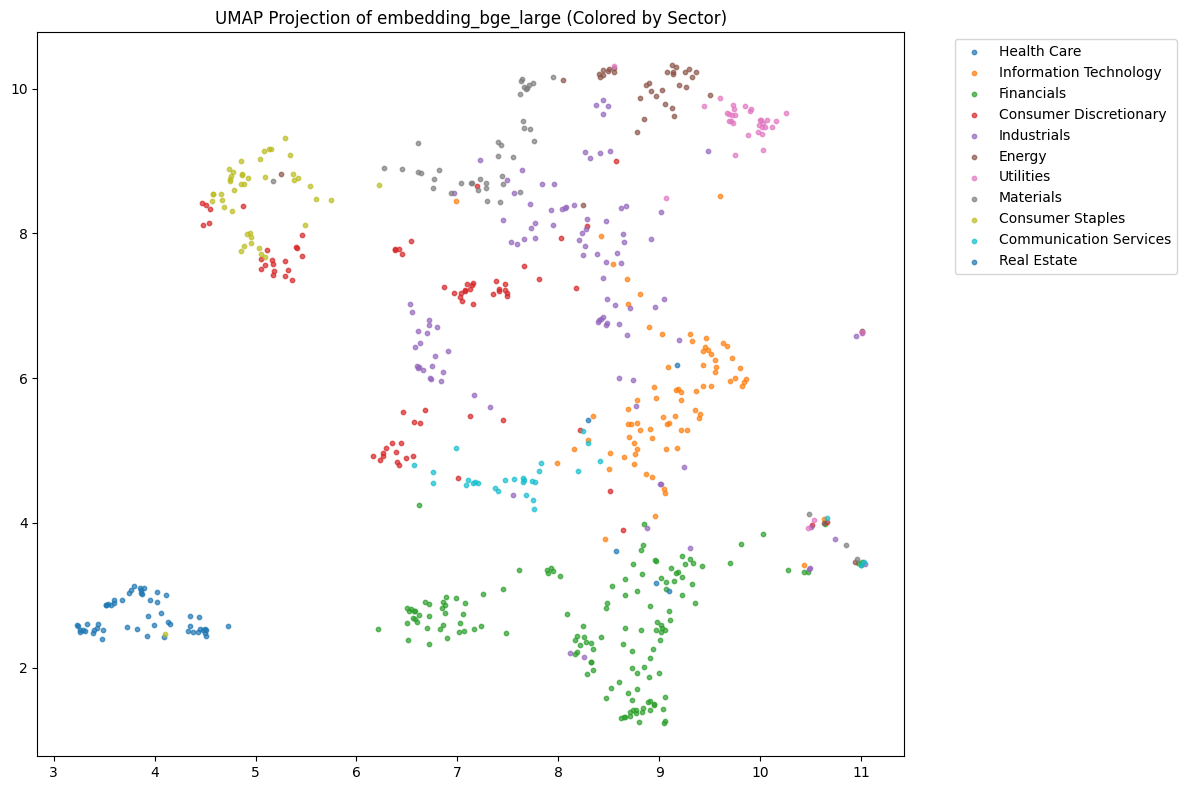

In [9]:
import umap

# Use the best model from above
best_col = results_df.iloc[0]['Model']
matrix = np.stack(df[best_col].values)

print(f"Projecting {best_col} to 2D...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
projections = reducer.fit_transform(matrix)

# Plot
plt.figure(figsize=(12, 8))
# Color by sector
unique_sectors = df['sector'].unique()
for sector in unique_sectors:
    mask = df['sector'] == sector
    plt.scatter(
        projections[mask, 0],
        projections[mask, 1],
        label=sector,
        s=10,
        alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"UMAP Projection of {best_col} (Colored by Sector)")
plt.tight_layout()
plt.show()

In [ ]:
############################################################ END OF FILE ############################################################